# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**Team-14**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.
 
### Predict Overview: Climate Change Belief Analysis 2022 Challenge

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

- 1. analyse the supplied data;
- 2. identify potential errors in the data and clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of classifying whether or not a person believes in climate change;
- 5. evaluate the accuracy of the best machine learning model;
- 6. determine what features were most important in the model’s prediction decision, and
- 7. explain the inner working of the model to a non-technical audience.

Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in `climate change`, based on their `novel tweet data`.

> Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.
On top of this, she has provided you with a starter notebook containing vague explanations of what the main outcomes are. 

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [1]:
# Libraries for data loading, data manipulation and data visulisation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import neattext.functions as nt

import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams

# Libraries for data preparation and model building
from sklearn.feature_extraction.text import CountVectorizer


# set plot style
sns.set()


#import *

# Setting global constants to ensure notebook results are reproducible
#PARAMETER_CONSTANT = ###

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [2]:
pd.set_option('display.max_colwidth', None)
df_train = pd.read_csv('train.csv') # load the data
#df_test = pd.read_csv('test.csv') # load the data

In [3]:
# View dataset
df_train.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


Class Description (Sentiments)
* 2  : News: the tweet links to factual news about climate change
* 1  : Pro: the tweet supports the belief of man-made climate change
* 0  : Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1: Anti: the tweet does not believe in man-made climate change

List of all the Sentiments types which are present in this dataset

In [4]:
# list of unique types of Sentiments
type_sentis = list(sorted(df_train.sentiment.unique()))
print(type_sentis)

[-1, 0, 1, 2]


Data samples for each of the different Sentiment types

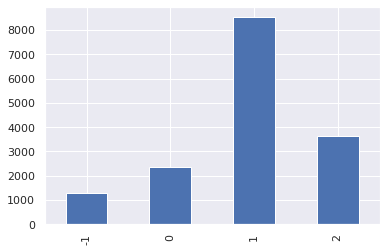

In [5]:
df_train['sentiment'].value_counts().sort_index().plot(kind = 'bar')
plt.show()

In [6]:
df_train.describe(include='object')

,message
count,15819
unique,14229
top,RT @StephenSchlegel: she's thinking about how she's going to die because your husband doesn't believe in climate change https://t.co/SjoFoNÃ¢â‚¬Â¦
freq,307


For our dataset, we will be doing the following steps:
* removing the web-urls
* making everything lower case
* removing punctuation and special characters
* removing mentions and retweets(`rt`)

In [7]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_train['message'] = df_train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

Make all text lowercase

In [8]:
df_train['message'] = df_train['message'].str.lower()

Now, we create a funcion that will remove the web-urls, punctuation, and mentions along with retweets(`rt`)

In [9]:
def data_cleaning(tweet):
    tweet = re.sub(r'@[a-z0-9]+', '', tweet) # removing mentions
    tweet = re.sub(r'#', '', tweet) # remove #
    tweet = re.sub(r'rt[\s]+', '', tweet) # remove retweets(`rt`)
    #tweet = re.sub(r'url-web', '', tweet) # remove web-urls
    
    return tweet

In [10]:
df_train['clean_message'] = df_train['message'].apply(data_cleaning)

In [11]:
df_train.head()

,sentiment,message,tweetid,clean_message
0,1,"polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? url-web via @mashable",625221,"polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? url-web via"
1,1,it's not like we lack evidence of anthropogenic global warming,126103,it's not like we lack evidence of anthropogenic global warming
2,2,rt @rawstory: researchers say we have three years to act on climate change before it’s too late url-web url-web…,698562,: researchers say we have three years to act on climate change before it’s too late url-web url-web…
3,1,#todayinmaker# wired : 2016 was a pivotal year in the war on climate change url-web,573736,todayinmaker wired : 2016 was a pivotal year in the war on climate change url-web
4,1,"rt @soynoviodetodas: it's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #electionnight",466954,": it's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. electionnight"


In case of special characters and extra whitespace, we employed NeatText 

In [12]:
# Remove special characters using NeatText
df_train['clean_message'] = df_train['clean_message'].apply(nt.remove_special_characters)

In [13]:
# Remove multiple whitespace between words
df_train['clean_message'] = df_train['clean_message'].apply(nt.remove_multiple_spaces)

In [14]:
df_train['clean_message'].iloc[7]

' six big things we can all do today to fight climate change or how to be a climate activist urlweb h'

In [15]:
df_train['clean_message'].iloc[9]

' no offense but like how do you just not believe in global warming'

In [16]:
df_train[['message','clean_message']].head()

,message,clean_message
0,"polyscimajor epa chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? url-web via @mashable",polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via
1,it's not like we lack evidence of anthropogenic global warming,its not like we lack evidence of anthropogenic global warming
2,rt @rawstory: researchers say we have three years to act on climate change before it’s too late url-web url-web…,researchers say we have three years to act on climate change before its too late urlweb urlweb
3,#todayinmaker# wired : 2016 was a pivotal year in the war on climate change url-web,todayinmaker wired 2016 was a pivotal year in the war on climate change urlweb
4,"rt @soynoviodetodas: it's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #electionnight",its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight


In [17]:
df_train = df_train.drop('message', axis=1)

In [18]:
df_train.head(10)

,sentiment,tweetid,clean_message
0,1,625221,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via
1,1,126103,its not like we lack evidence of anthropogenic global warming
2,2,698562,researchers say we have three years to act on climate change before its too late urlweb urlweb
3,1,573736,todayinmaker wired 2016 was a pivotal year in the war on climate change urlweb
4,1,466954,its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight
5,1,425577,worth a read whether you do or dont believe in climate change urlweb urlweb
6,1,294933,mike pence doesnt believe in global warming or that smoking causes lung cancer urlweb
7,1,992717,six big things we can all do today to fight climate change or how to be a climate activist urlweb h
8,1,664510,my 8yo nephew is inconsolable he wants to die of old age like me but will perish in the fiery hellscape of climate change
9,1,260471,no offense but like how do you just not believe in global warming


In [19]:
df_train['clean_message'].iloc[7]

' six big things we can all do today to fight climate change or how to be a climate activist urlweb h'

In [20]:
df_train['clean_message'].iloc[9]

' no offense but like how do you just not believe in global warming'

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---

df.info() will show column datatypes, nubmer of rows, and if they are null values

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentiment      15819 non-null  int64 
 1   tweetid        15819 non-null  int64 
 2   clean_message  15819 non-null  object
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


`sentiment` and `tweetid` columns contains Numerical data, while `clean_message` contain Categorical data

To run summary statistics on columns containing `Numerical data`, we use `.describe()` function

In [22]:
df_train.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


Summary statistics on `Categorical` column

In [23]:
df_train.describe(include='object')

,clean_message
count,15819
unique,13651
top,shes thinking about how shes going to die because your husband doesnt believe in climate change urlweb
freq,308


We notice that there are duplicates in the clean_message column, as shown by the unique row. These could be messages retweeted by different people.   

Possible solution would be to drop the duplicate columns. 

train = df_train.drop_duplicates(subset=['clean_message'])


train.describe(include='object')

In [25]:
for i in df_train.columns:
    print(i,"--->",df_train[i].nunique(),"--->",df_train[i].dtypes)

sentiment ---> 4 ---> int64
tweetid ---> 15819 ---> int64
clean_message ---> 13651 ---> object


In [26]:
df_train.isnull().sum()

sentiment        0
tweetid          0
clean_message    0
dtype: int64

No null values present in all columns

In [58]:
# look at data statistics

In [59]:
# plot relevant feature interactions

In [60]:
# evaluate correlation

In [61]:
# have a look at feature distributions

Tokenization

In [21]:
from nltk.tokenize import word_tokenize, TreebankWordTokenizer

In [22]:
tokeniser = TreebankWordTokenizer()
df_train['tokens'] = df_train['clean_message'].apply(tokeniser.tokenize)

In [23]:
df_train['tokens'].iloc[9]

['no',
 'offense',
 'but',
 'like',
 'how',
 'do',
 'you',
 'just',
 'not',
 'believe',
 'in',
 'global',
 'warming']

#### Stemming

In [24]:
stemmer = SnowballStemmer('english')

In [25]:
def dset_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

In [26]:
df_train['stem'] = df_train['tokens'].apply(dset_stemmer, args=(stemmer, ))

In [27]:
for i, t in enumerate(df_train.iloc[9]['tokens']):    
    print ('{:20s} --> {:10s}'.format(t, df_train.iloc[9]['stem'][i]))

no                   --> no        
offense              --> offens    
but                  --> but       
like                 --> like      
how                  --> how       
do                   --> do        
you                  --> you       
just                 --> just      
not                  --> not       
believe              --> believ    
in                   --> in        
global               --> global    
warming              --> warm      


### Lemmatization


In [28]:
lemmatizer = WordNetLemmatizer()

In [29]:
print(lemmatizer.lemmatize("cats"))
print(lemmatizer.lemmatize("cacti"))
print(lemmatizer.lemmatize("geese"))
print(lemmatizer.lemmatize("rocks"))
print(lemmatizer.lemmatize("python"))
print(lemmatizer.lemmatize("better", pos="a"))
print(lemmatizer.lemmatize("best", pos="a"))
print(lemmatizer.lemmatize("run"))
print(lemmatizer.lemmatize("ran",'v'))

cat
cactus
goose
rock
python
good
best
run
run


In [30]:
def dset_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]    

In [31]:
df_train['lemma'] = df_train['tokens'].apply(dset_lemma, args=(lemmatizer, ))

In [32]:
for i, t in enumerate(df_train.iloc[13]['tokens']):    
    print ('{:20s} --> {:10s}'.format(t, df_train.iloc[13]['lemma'][i]))

oh                   --> oh        
my                   --> my        
godtrumps            --> godtrumps 
government           --> government
removes              --> remove    
climate              --> climate   
change               --> change    
page                 --> page      
from                 --> from      
epa                  --> epa       
website              --> website   
hours                --> hour      
ahead                --> ahead     
of                   --> of        
climatemarchurlweb   --> climatemarchurlweb


In [33]:
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

In [34]:
#df_train['stop_w'] = df_train['tokens'].apply(remove_stop_words)

In [35]:
df_train.describe(include='object')

,clean_message,tokens,stem,lemma
count,15819,15819,15819,15819
unique,13651,13506,13503,13504
top,shes thinking about how shes going to die because your husband doesnt believe in climate change urlweb,"[shes, thinking, about, how, shes, going, to, die, because, your, husband, doesnt, believe, in, climate, change, urlweb]","[shes, think, about, how, shes, go, to, die, becaus, your, husband, doesnt, believ, in, climat, chang, urlweb]","[shes, thinking, about, how, shes, going, to, die, because, your, husband, doesnt, believe, in, climate, change, urlweb]"
freq,308,308,308,308


## WordCloud image of words from tweets that are Pro man-made Climate Change

In [36]:
pro_climate_change_tweets = df_train[df_train.sentiment == 1]
pro_climate_string = []
for p in pro_climate_change_tweets.clean_message:
    pro_climate_string.append(p)
pro_climate_string = pd.Series(pro_climate_string).str.cat(sep=' ')


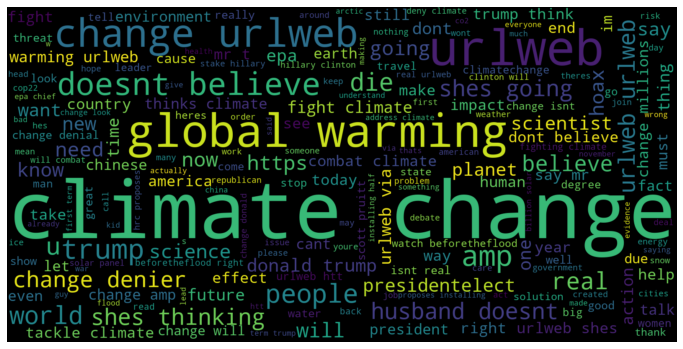

In [37]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pro_climate_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## WordCloud image of words from tweets that are Anti man-made Climate Change

In [38]:
anti_climate_change_tweets = df_train[df_train.sentiment == -1]
anti_climate_string = []
for p in anti_climate_change_tweets.clean_message:
    anti_climate_string.append(p)
anti_climate_string = pd.Series(anti_climate_string).str.cat(sep=' ')

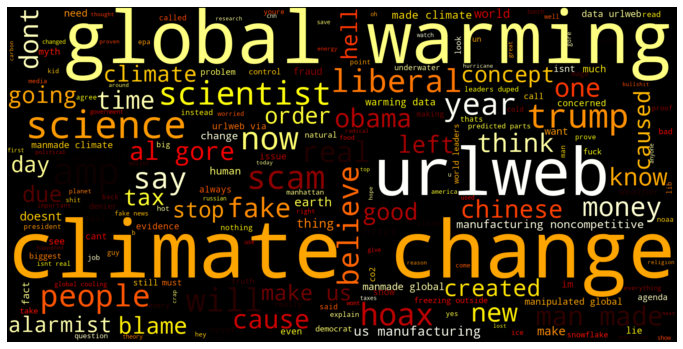

In [39]:
#from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='hot').generate(anti_climate_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## WordCloud image of words from tweets that are from the NEWS

In [40]:
news_climate_change_tweets = df_train[df_train.sentiment == 2]
news_climate_string = []
for p in news_climate_change_tweets.clean_message:
    news_climate_string.append(p)
news_climate_string = pd.Series(news_climate_string).str.cat(sep=' ')

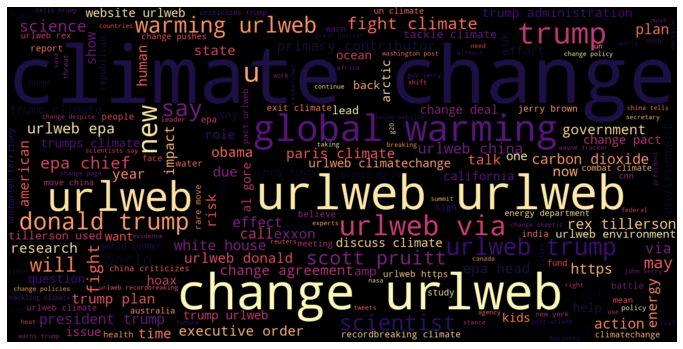

In [41]:
#from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(news_climate_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [42]:
#predictor names
#betterVect.get_feature_names()

## PREPARING TEST DATASET

In [43]:
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


In [44]:
#remove urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_test['message'] = df_test['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

df_test['message'] = df_test['message'].str.lower()

In [45]:
df_test['message'] = df_test['message'].apply(data_cleaning)

In case of special characters and extra whitespace, we employed NeatText 

In [46]:
# Remove special characters using NeatText
df_test['message'] = df_test['message'].apply(nt.remove_special_characters)

In [47]:
# Remove multiple whitespace between words
df_test['message'] = df_test['message'].apply(nt.remove_multiple_spaces)

In [48]:
df_test.head(10)

,message,tweetid
0,europe will now be looking to china to make sure that it is not alone in fighting climate change urlweb,169760
1,combine this with the polling of staffers re climate change and womens rights and you have a fascist state urlweb,35326
2,the scary unimpeachable evidence that climate change is already here urlweb itstimetochange climatechange,224985
3,putin got to you too jill trump doesnt believe in climate change at all thinks its s hoax,476263
4,female orgasms cause global warmingsarcastic republican,872928
5,trump muzzles employees of several govt agencies in effoto suppress info on climate change amp the environment urlweb,75639
6,yes wrote that in 3rd yr comp sci ethics part was told by climate change denying lecturer that i was wrong amp marked down,211536
7,indonesian farmers weather climate change w conservation agriculture urlweb,569434
8,british scientists face a huge hit if the us cuts climate change research urlweb,315368
9,aid for agriculture sustainable agriculture and climate change adaptation for smallscale farmers urlweb via,591733


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentiment      15819 non-null  int64 
 1   tweetid        15819 non-null  int64 
 2   clean_message  15819 non-null  object
 3   tokens         15819 non-null  object
 4   stem           15819 non-null  object
 5   lemma          15819 non-null  object
dtypes: int64(2), object(4)
memory usage: 741.6+ KB


In [ ]:
df_train.describe()

In [54]:
df_train.describe(include='object')

,clean_message,tokens,stem,lemma
count,15819,15819,15819,15819
unique,13651,13506,13503,13504
top,shes thinking about how shes going to die because your husband doesnt believe in climate change urlweb,"[shes, thinking, about, how, shes, going, to, die, because, your, husband, doesnt, believe, in, climate, change, urlweb]","[shes, think, about, how, shes, go, to, die, becaus, your, husband, doesnt, believ, in, climat, chang, urlweb]","[shes, thinking, about, how, shes, going, to, die, because, your, husband, doesnt, believe, in, climate, change, urlweb]"
freq,308,308,308,308


We notice in our

train = df_train.drop_duplicates(subset=['clean_message'])


train.describe(include='object')

for i in df_train.columns:
    print(i,"--->",df_train[i].nunique(),"--->",df_train[i].dtypes)

In [55]:
df_train.isnull().sum()

sentiment        0
tweetid          0
clean_message    0
tokens           0
stem             0
lemma            0
dtype: int64

In [56]:
df_train = df_train.drop_duplicates(subset=['clean_message'])

In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13651 entries, 0 to 15818
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentiment      13651 non-null  int64 
 1   tweetid        13651 non-null  int64 
 2   clean_message  13651 non-null  object
 3   tokens         13651 non-null  object
 4   stem           13651 non-null  object
 5   lemma          13651 non-null  object
dtypes: int64(2), object(4)
memory usage: 746.5+ KB


In [58]:
# look at data statistics

In [59]:
# plot relevant feature interactions

In [60]:
# evaluate correlation

In [61]:
# have a look at feature distributions

#### Tokenize

In [49]:
#tokeniser = TreebankWordTokenizer()
df_test['tokens'] = df_test['message'].apply(tokeniser.tokenize)

#### Stemming

In [50]:
df_test['stem'] = df_test['tokens'].apply(dset_stemmer, args=(stemmer, ))

#### Lemmatization

In [51]:
df_test['lemma'] = df_test['tokens'].apply(dset_lemma, args=(lemmatizer, ))

anti_doc_matrix = vect.transform(df_train[df_train.sentiment == -1].clean_message)
pro_doc_matrix = vect.transform(df_train[df_train.sentiment == 1].clean_message)
neut_doc_matrix = vect.transform(df_train[df_train.sentiment == 0].clean_message)
news_doc_matrix = vect.transform(df_train[df_train.sentiment == 2].clean_message)

anti_tf = np.sum(anti_doc_matrix,axis=0)
pro_tf = np.sum(pro_doc_matrix,axis=0)
neut_tf = np.sum(neut_doc_matrix,axis=0)
news_tf = np.sum(news_doc_matrix,axis=0)

anti = np.squeeze(np.asarray(anti_tf))
pro = np.squeeze(np.asarray(pro_tf))
neut = np.squeeze(np.asarray(neut_tf))
news = np.squeeze(np.asarray(news_tf))

term_freq_df = pd.DataFrame([anti,pro,neut,news],columns=vect.get_feature_names_out()).transpose()

term_freq_df.head()

In [52]:
df_train.head()

,sentiment,tweetid,clean_message,tokens,stem,lemma
0,1,625221,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, urlweb, via]","[polyscimajor, epa, chief, doesnt, think, carbon, dioxid, is, main, caus, of, global, warm, and, wait, what, urlweb, via]","[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, urlweb, via]"
1,1,126103,its not like we lack evidence of anthropogenic global warming,"[its, not, like, we, lack, evidence, of, anthropogenic, global, warming]","[it, not, like, we, lack, evid, of, anthropogen, global, warm]","[it, not, like, we, lack, evidence, of, anthropogenic, global, warming]"
2,2,698562,researchers say we have three years to act on climate change before its too late urlweb urlweb,"[researchers, say, we, have, three, years, to, act, on, climate, change, before, its, too, late, urlweb, urlweb]","[research, say, we, have, three, year, to, act, on, climat, chang, befor, it, too, late, urlweb, urlweb]","[researcher, say, we, have, three, year, to, act, on, climate, change, before, it, too, late, urlweb, urlweb]"
3,1,573736,todayinmaker wired 2016 was a pivotal year in the war on climate change urlweb,"[todayinmaker, wired, 2016, was, a, pivotal, year, in, the, war, on, climate, change, urlweb]","[todayinmak, wire, 2016, was, a, pivot, year, in, the, war, on, climat, chang, urlweb]","[todayinmaker, wired, 2016, wa, a, pivotal, year, in, the, war, on, climate, change, urlweb]"
4,1,466954,its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight,"[its, 2016, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, polls, electionnight]","[it, 2016, and, a, racist, sexist, climat, chang, deni, bigot, is, lead, in, the, poll, electionnight]","[it, 2016, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, poll, electionnight]"


<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

In [62]:
# remove missing values/ features

## Text feature extraction

### Bag of words

Text feature extraction is the process of transforming what is essentially a list of words into a feature set that is usable by a classifier. The NLTK classifiers expect `dict` style feature sets, so we must therefore transform our text into a `dict`. The Bag of Words model is the simplest method; it constructs a word presence feature set from all the words in the text, indicating the number of times each word has appeared.

def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

### ngrams

While individual words do carry meaning, it is often the case that combinations of words change meanings of sentences entirely.  For example, what difference does removing the `not` from this sentence make?

Natural Language Processing is **not** easy!

ngrams are a method to extract combinations of words into features for model buildiing.  The `n` in ngrams specifies the number of tokens to include.  For example, a 2-gram returns all the consecutive pairs of words in a sentence.

In [63]:
def word_grams(words, min_n=1, max_n=4):
    s = []
    for n in range(min_n, max_n):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

In [64]:
print (word_grams('one two three four'.split(' ')))

['one', 'two', 'three', 'four', 'one two', 'two three', 'three four', 'one two three', 'two three four']


Let's combine consecutive words into groups of 2 using ngrams.

In [65]:
[x for x in ngrams(df_train.iloc[7]['tokens'], 2)]

[('six', 'big'),
 ('big', 'things'),
 ('things', 'we'),
 ('we', 'can'),
 ('can', 'all'),
 ('all', 'do'),
 ('do', 'today'),
 ('today', 'to'),
 ('to', 'fight'),
 ('fight', 'climate'),
 ('climate', 'change'),
 ('change', 'or'),
 ('or', 'how'),
 ('how', 'to'),
 ('to', 'be'),
 ('be', 'a'),
 ('a', 'climate'),
 ('climate', 'activist'),
 ('activist', 'urlweb'),
 ('urlweb', 'h')]

Now let's combine consecutive words into groups of 3 using ngrams.

In [66]:
[x for x in ngrams(df_train.iloc[7]['tokens'], 3)]

[('six', 'big', 'things'),
 ('big', 'things', 'we'),
 ('things', 'we', 'can'),
 ('we', 'can', 'all'),
 ('can', 'all', 'do'),
 ('all', 'do', 'today'),
 ('do', 'today', 'to'),
 ('today', 'to', 'fight'),
 ('to', 'fight', 'climate'),
 ('fight', 'climate', 'change'),
 ('climate', 'change', 'or'),
 ('change', 'or', 'how'),
 ('or', 'how', 'to'),
 ('how', 'to', 'be'),
 ('to', 'be', 'a'),
 ('be', 'a', 'climate'),
 ('a', 'climate', 'activist'),
 ('climate', 'activist', 'urlweb'),
 ('activist', 'urlweb', 'h')]

Text feature extraction module called CountVectorizer is used to convert a collection of documents (rows of text) into a matrix of token counts.

In [67]:
vect = CountVectorizer()
vect.fit(df_train['clean_message'])

CountVectorizer()

In [68]:
len(vect.get_feature_names_out())

18528

In [69]:
len(vect.vocabulary_)

18528

In [70]:
vect_transform=vect.transform(df_train['clean_message'])

# Get shape of our predictive variables
vect_transform.shape

(13651, 18528)

In [71]:
#total number of words in corpus
total_corpus=sum(vect_transform.toarray().sum(axis=0))
total_corpus

210141

We can seee that there are a lot more features(24 819) than rows (15 819) a lot of which correspond to words which only appear once. Not all of them are very useful, we must therefore tune vectorizer.

In [72]:
betterVect = CountVectorizer(stop_words='english',max_features=10000) 

betterVect.fit(df_train['clean_message'])

CountVectorizer(max_features=10000, stop_words='english')

In [73]:
print(len(betterVect.vocabulary_))

10000


In [74]:
betterVect_transform=betterVect.transform(df_train['clean_message'])

# Get shape of our predictive variables
betterVect_transform.shape

(13651, 10000)

In [75]:
#get total words in better corpus
total_better_corpus=sum(betterVect_transform.toarray().sum(axis=0))
total_better_corpus

129839

In [76]:
#percentage of words used 
feature_percentage=round((total_better_corpus/total_corpus)*100)
feature_percentage

62

## Tune Vectorizer for test

In [77]:
betterVect_test = CountVectorizer(stop_words='english',max_features=10000)

vect_fit_test=betterVect_test.fit(df_test['message'])

betterVect_transform_test=betterVect_test.transform(df_test['message'])

feat_test=betterVect_transform_test.toarray()

In [78]:
# create new features

In [79]:
# engineer existing features

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

In [80]:
# split data

In [81]:
# create targets and features dataset

In [82]:
# create one or more ML models

In [83]:
# evaluate one or more ML models

## Logistic Regression Model

In [84]:
X = betterVect_transform.toarray()
y = df_train['sentiment']

my_ys = df_train.copy()
my_ys.tail(10)


my_ys = my_ys.drop(labels=['tweetid','clean_message','tokens','stem','lemma'],axis=1)

my_ys.tail(10)

my_ys['new_y'] = my_ys.sentiment.replace({-1: 0, 0: 1, 1: 2, 2: 3})
my_ys.tail(10)

y_new = my_ys['new_y']

In [85]:
# import train/test split module
from sklearn.model_selection import train_test_split

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [86]:
# import logistic regression module
from sklearn.linear_model import LogisticRegression

# create model object
lr = LogisticRegression(multi_class='ovr',max_iter=200)

# train model
lr.fit(X_train, y_train)

LogisticRegression(max_iter=200, multi_class='ovr')

### Checking outcomes on the testing set

In [87]:
# Generate predictions
y_pred_test = lr.predict(X_test)

y_pred=pd.DataFrame(y_pred_test)

In [88]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

import warnings
warnings.filterwarnings('ignore')

              precision    recall  f1-score   support

          -1       0.70      0.37      0.48       251
           0       0.49      0.38      0.43       439
           1       0.70      0.82      0.75      1408
           2       0.70      0.68      0.69       633

    accuracy                           0.67      2731
   macro avg       0.65      0.56      0.59      2731
weighted avg       0.67      0.67      0.66      2731



# Predictions on Test

In [89]:
preds=lr.predict(feat_test)

In [90]:
len(preds)

10546

In [91]:
daf=pd.DataFrame(preds,columns=['sentiment'])
daf.head(2)

,sentiment
0,1
1,1


output=pd.DataFrame({'tweetid':df_test['tweetid']})
submission=output.join(daf)
submission.to_csv('submission_02.csv',index=False)

submission

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [92]:
# Compare model performance

In [93]:
# Choose best model and motivate why it is the best choice

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [94]:
# discuss chosen methods logic